# Using LightGBM classifier on credit card user data to predict default rate

This notebook utilizes the LightGBM package by Microsoft with a clean dataset on credit card defaults (source: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). Since we are trying to predict if a person is defaulting or not, we will want to use binary classification. This notebook also explores early stopping, a form of regularization used to avoid overfitting when training a learner with an iterative method, such as gradient descent. Such methods update the learner so as to make it better fit the training data with each iteration.

In [77]:
import pandas as pd
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
%matplotlib inline
import matplotlib.pyplot as plt

In [40]:
data = pd.read_excel('ccdata.xls', header = 1)

In [41]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


This research employed a binary variable, default payment (Yes = 1, No = 0), as the response variable. This study reviewed the literature and used the following 23 variables as explanatory variables:
- X1: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit.
- X2: Gender (1 = male; 2 = female).
- X3: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- X4: Marital status (1 = married; 2 = single; 3 = others).
- X5: Age (year).
- X6 - X11: History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: X6 = the repayment status in September, 2005; X7 = the repayment status in August, 2005; . . .;X11 = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
- X12-X17: Amount of bill statement (NT dollar). X12 = amount of bill statement in September, 2005; X13 = amount of bill statement in August, 2005; . . .; X17 = amount of bill statement in April, 2005.
- X18-X23: Amount of previous payment (NT dollar). X18 = amount paid in September, 2005; X19 = amount paid in August, 2005; . . .;X23 = amount paid in April, 2005.


In [42]:
data.drop('ID', axis = 1, inplace = True)

In [43]:
# Check for null values. 
data.isnull().sum().sort_values(ascending=False)

default payment next month    0
PAY_AMT6                      0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
LIMIT_BAL                     0
dtype: int64

Thank god there are no missing values! If there were, we would have to either drop the feature if 
there are more than 60% of the values are missing, or impute them. 

In [44]:
# Outlier Detection in this cell.
# For each column, first it computes the Z-score of each value in the column,
# relative to the column mean and standard deviation. Then is takes the absolute 
# of Z-score because the direction does not matter, only if it is below the threshold.
# all(axis=1) ensures that for each row, all column satisfy the constraint. 
data = data[data.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]

In [45]:
# Below, we separate our target variable from our dataset. 
X = data.drop(['default payment next month'], axis=1)
y = data['default payment next month']

In [46]:



# Let's then put 85% of our dataset into a training set and 15% of it into a test set. 
# We can use random_state because it is not a time series dataset that we are using.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=20)
X_train.shape


(22464, 23)

<h2>LightGBM classifier hyperparameter optimization via scikit-learn's GridSearchCV</h2>

In [52]:
estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)


param_grid = {
    'n_estimators': [x for x in range(24,40,2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}
gridsearch = GridSearchCV(estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)



/home/ajc/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's binary_logloss: 0.650853	valid_0's auc: 0.749019
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.616135	valid_0's auc: 0.752078
[3]	valid_0's binary_logloss: 0.587752	valid_0's auc: 0.755301
[4]	valid_0's binary_logloss: 0.564477	valid_0's auc: 0.756622
[5]	valid_0's binary_logloss: 0.544594	valid_0's auc: 0.760193
[6]	valid_0's binary_logloss: 0.527785	valid_0's auc: 0.760906
[7]	valid_0's binary_logloss: 0.513856	valid_0's auc: 0.761905
[8]	valid_0's binary_logloss: 0.502076	valid_0's auc: 0.76343
[9]	valid_0's binary_logloss: 0.491974	valid_0's auc: 0.763981
[10]	valid_0's binary_logloss: 0.483799	valid_0's auc: 0.763893
[11]	valid_0's binary_logloss: 0.476724	valid_0's auc: 0.765105
[12]	valid_0's binary_logloss: 0.470592	valid_0's auc: 0.766134
[13]	valid_0's binary_logloss: 0.465488	valid_0's auc: 0.766579
[14]	valid_0's binary_logloss: 0.4612	valid_0's auc: 0.766906
[15]	valid_0's binary_logloss: 0.458058	valid_0's auc: 

[1]	valid_0's binary_logloss: 0.650327	valid_0's auc: 0.754322
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.61564	valid_0's auc: 0.757175
[3]	valid_0's binary_logloss: 0.586972	valid_0's auc: 0.764043
[4]	valid_0's binary_logloss: 0.562638	valid_0's auc: 0.766654
[5]	valid_0's binary_logloss: 0.542872	valid_0's auc: 0.766568
[6]	valid_0's binary_logloss: 0.52609	valid_0's auc: 0.768887
[7]	valid_0's binary_logloss: 0.512487	valid_0's auc: 0.769703
[8]	valid_0's binary_logloss: 0.500321	valid_0's auc: 0.771338
[9]	valid_0's binary_logloss: 0.490032	valid_0's auc: 0.772365
[10]	valid_0's binary_logloss: 0.481959	valid_0's auc: 0.770874
[11]	valid_0's binary_logloss: 0.475167	valid_0's auc: 0.771372
[12]	valid_0's binary_logloss: 0.46925	valid_0's auc: 0.770875
[13]	valid_0's binary_logloss: 0.464184	valid_0's auc: 0.771062
[14]	valid_0's binary_logloss: 0.460043	valid_0's auc: 0.770341
Early stopping, best iteration is:
[9]	valid_0's binary

[1]	valid_0's binary_logloss: 0.650853	valid_0's auc: 0.749019
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.616135	valid_0's auc: 0.752078
[3]	valid_0's binary_logloss: 0.587752	valid_0's auc: 0.755301
[4]	valid_0's binary_logloss: 0.564477	valid_0's auc: 0.756622
[5]	valid_0's binary_logloss: 0.544594	valid_0's auc: 0.760193
[6]	valid_0's binary_logloss: 0.527785	valid_0's auc: 0.760906
[7]	valid_0's binary_logloss: 0.513856	valid_0's auc: 0.761905
[8]	valid_0's binary_logloss: 0.502076	valid_0's auc: 0.76343
[9]	valid_0's binary_logloss: 0.491974	valid_0's auc: 0.763981
[10]	valid_0's binary_logloss: 0.483799	valid_0's auc: 0.763893
[11]	valid_0's binary_logloss: 0.476724	valid_0's auc: 0.765105
[12]	valid_0's binary_logloss: 0.470592	valid_0's auc: 0.766134
[13]	valid_0's binary_logloss: 0.465488	valid_0's auc: 0.766579
[14]	valid_0's binary_logloss: 0.4612	valid_0's auc: 0.766906
[15]	valid_0's binary_logloss: 0.458058	valid_0's auc: 

[8]	valid_0's binary_logloss: 0.500321	valid_0's auc: 0.771338
[9]	valid_0's binary_logloss: 0.490032	valid_0's auc: 0.772365
[10]	valid_0's binary_logloss: 0.481959	valid_0's auc: 0.770874
[11]	valid_0's binary_logloss: 0.475167	valid_0's auc: 0.771372
[12]	valid_0's binary_logloss: 0.46925	valid_0's auc: 0.770875
[13]	valid_0's binary_logloss: 0.464184	valid_0's auc: 0.771062
[14]	valid_0's binary_logloss: 0.460043	valid_0's auc: 0.770341
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.490032	valid_0's auc: 0.772365
[1]	valid_0's binary_logloss: 0.650309	valid_0's auc: 0.754597
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.615779	valid_0's auc: 0.756524
[3]	valid_0's binary_logloss: 0.586994	valid_0's auc: 0.759714
[4]	valid_0's binary_logloss: 0.563245	valid_0's auc: 0.761988
[5]	valid_0's binary_logloss: 0.54326	valid_0's auc: 0.763567
[6]	valid_0's binary_logloss: 0.526682	valid_0's auc: 0.762949
[7]	valid_0's binar

[4]	valid_0's binary_logloss: 0.543679	valid_0's auc: 0.75906
[5]	valid_0's binary_logloss: 0.523356	valid_0's auc: 0.762148
[6]	valid_0's binary_logloss: 0.507119	valid_0's auc: 0.760809
[7]	valid_0's binary_logloss: 0.493783	valid_0's auc: 0.763779
[8]	valid_0's binary_logloss: 0.482963	valid_0's auc: 0.764698
[9]	valid_0's binary_logloss: 0.474584	valid_0's auc: 0.765261
[10]	valid_0's binary_logloss: 0.467761	valid_0's auc: 0.76567
[11]	valid_0's binary_logloss: 0.462211	valid_0's auc: 0.765548
[12]	valid_0's binary_logloss: 0.457512	valid_0's auc: 0.766293
[13]	valid_0's binary_logloss: 0.453961	valid_0's auc: 0.766222
[14]	valid_0's binary_logloss: 0.451213	valid_0's auc: 0.766377
[15]	valid_0's binary_logloss: 0.449126	valid_0's auc: 0.766314
[16]	valid_0's binary_logloss: 0.447457	valid_0's auc: 0.765742
[17]	valid_0's binary_logloss: 0.445718	valid_0's auc: 0.766506
[18]	valid_0's binary_logloss: 0.444613	valid_0's auc: 0.766507
[19]	valid_0's binary_logloss: 0.443095	valid_0'

[1]	valid_0's binary_logloss: 0.640346	valid_0's auc: 0.754322
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.599816	valid_0's auc: 0.756783
[3]	valid_0's binary_logloss: 0.567876	valid_0's auc: 0.762467
[4]	valid_0's binary_logloss: 0.542429	valid_0's auc: 0.763728
[5]	valid_0's binary_logloss: 0.522117	valid_0's auc: 0.765465
[6]	valid_0's binary_logloss: 0.506238	valid_0's auc: 0.765642
[7]	valid_0's binary_logloss: 0.493102	valid_0's auc: 0.765213
[8]	valid_0's binary_logloss: 0.481931	valid_0's auc: 0.768695
[9]	valid_0's binary_logloss: 0.473262	valid_0's auc: 0.769823
[10]	valid_0's binary_logloss: 0.466103	valid_0's auc: 0.769675
[11]	valid_0's binary_logloss: 0.460544	valid_0's auc: 0.769332
[12]	valid_0's binary_logloss: 0.456187	valid_0's auc: 0.769133
[13]	valid_0's binary_logloss: 0.452927	valid_0's auc: 0.76845
[14]	valid_0's binary_logloss: 0.44965	valid_0's auc: 0.769096
Early stopping, best iteration is:
[9]	valid_0's binar

[1]	valid_0's binary_logloss: 0.640322	valid_0's auc: 0.754597
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.600099	valid_0's auc: 0.756076
[3]	valid_0's binary_logloss: 0.567856	valid_0's auc: 0.761172
[4]	valid_0's binary_logloss: 0.542555	valid_0's auc: 0.764108
[5]	valid_0's binary_logloss: 0.522033	valid_0's auc: 0.765739
[6]	valid_0's binary_logloss: 0.505883	valid_0's auc: 0.764746
[7]	valid_0's binary_logloss: 0.492622	valid_0's auc: 0.766029
[8]	valid_0's binary_logloss: 0.482527	valid_0's auc: 0.763353
[9]	valid_0's binary_logloss: 0.474211	valid_0's auc: 0.76342
[10]	valid_0's binary_logloss: 0.467219	valid_0's auc: 0.763589
[11]	valid_0's binary_logloss: 0.461432	valid_0's auc: 0.765676
[12]	valid_0's binary_logloss: 0.456908	valid_0's auc: 0.766021
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.492622	valid_0's auc: 0.766029
[1]	valid_0's binary_logloss: 0.641006	valid_0's auc: 0.749019
Training until valid

[1]	valid_0's binary_logloss: 0.631448	valid_0's auc: 0.749019
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.586118	valid_0's auc: 0.751527
[3]	valid_0's binary_logloss: 0.552221	valid_0's auc: 0.756667
[4]	valid_0's binary_logloss: 0.526307	valid_0's auc: 0.759955
[5]	valid_0's binary_logloss: 0.506382	valid_0's auc: 0.760804
[6]	valid_0's binary_logloss: 0.490891	valid_0's auc: 0.763243
[7]	valid_0's binary_logloss: 0.478964	valid_0's auc: 0.764198
[8]	valid_0's binary_logloss: 0.46972	valid_0's auc: 0.764964
[9]	valid_0's binary_logloss: 0.462649	valid_0's auc: 0.76587
[10]	valid_0's binary_logloss: 0.457395	valid_0's auc: 0.765755
[11]	valid_0's binary_logloss: 0.453074	valid_0's auc: 0.766078
[12]	valid_0's binary_logloss: 0.449682	valid_0's auc: 0.766941
[13]	valid_0's binary_logloss: 0.447262	valid_0's auc: 0.76747
[14]	valid_0's binary_logloss: 0.445637	valid_0's auc: 0.76661
[15]	valid_0's binary_logloss: 0.444598	valid_0's auc: 0

[1]	valid_0's binary_logloss: 0.630622	valid_0's auc: 0.754597
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.585383	valid_0's auc: 0.755866
[3]	valid_0's binary_logloss: 0.550719	valid_0's auc: 0.762993
[4]	valid_0's binary_logloss: 0.524539	valid_0's auc: 0.764337
[5]	valid_0's binary_logloss: 0.504647	valid_0's auc: 0.765675
[6]	valid_0's binary_logloss: 0.489179	valid_0's auc: 0.76446
[7]	valid_0's binary_logloss: 0.47741	valid_0's auc: 0.765702
[8]	valid_0's binary_logloss: 0.468487	valid_0's auc: 0.765607
[9]	valid_0's binary_logloss: 0.461515	valid_0's auc: 0.766937
[10]	valid_0's binary_logloss: 0.455857	valid_0's auc: 0.767589
[11]	valid_0's binary_logloss: 0.451023	valid_0's auc: 0.770397
[12]	valid_0's binary_logloss: 0.448367	valid_0's auc: 0.768973
[13]	valid_0's binary_logloss: 0.446381	valid_0's auc: 0.768027
[14]	valid_0's binary_logloss: 0.444324	valid_0's auc: 0.768433
[15]	valid_0's binary_logloss: 0.443134	valid_0's auc:

[1]	valid_0's binary_logloss: 0.630654	valid_0's auc: 0.754322
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.585205	valid_0's auc: 0.757088
[3]	valid_0's binary_logloss: 0.550895	valid_0's auc: 0.761995
[4]	valid_0's binary_logloss: 0.524251	valid_0's auc: 0.766984
[5]	valid_0's binary_logloss: 0.504433	valid_0's auc: 0.770568
[6]	valid_0's binary_logloss: 0.489087	valid_0's auc: 0.770545
[7]	valid_0's binary_logloss: 0.47757	valid_0's auc: 0.770446
[8]	valid_0's binary_logloss: 0.468269	valid_0's auc: 0.770626
[9]	valid_0's binary_logloss: 0.460986	valid_0's auc: 0.770883
[10]	valid_0's binary_logloss: 0.455769	valid_0's auc: 0.769739
[11]	valid_0's binary_logloss: 0.451533	valid_0's auc: 0.769676
[12]	valid_0's binary_logloss: 0.448643	valid_0's auc: 0.769198
[13]	valid_0's binary_logloss: 0.446163	valid_0's auc: 0.77009
[14]	valid_0's binary_logloss: 0.444737	valid_0's auc: 0.769141
Early stopping, best iteration is:
[9]	valid_0's binar

[3]	valid_0's binary_logloss: 0.537466	valid_0's auc: 0.758069
[4]	valid_0's binary_logloss: 0.511338	valid_0's auc: 0.762643
[5]	valid_0's binary_logloss: 0.492212	valid_0's auc: 0.764072
[6]	valid_0's binary_logloss: 0.478392	valid_0's auc: 0.763836
[7]	valid_0's binary_logloss: 0.467832	valid_0's auc: 0.765215
[8]	valid_0's binary_logloss: 0.459919	valid_0's auc: 0.767165
[9]	valid_0's binary_logloss: 0.45493	valid_0's auc: 0.765335
[10]	valid_0's binary_logloss: 0.450702	valid_0's auc: 0.766173
[11]	valid_0's binary_logloss: 0.44805	valid_0's auc: 0.766415
[12]	valid_0's binary_logloss: 0.445777	valid_0's auc: 0.76658
[13]	valid_0's binary_logloss: 0.444291	valid_0's auc: 0.766313
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.459919	valid_0's auc: 0.767165
[1]	valid_0's binary_logloss: 0.621248	valid_0's auc: 0.754322
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.571859	valid_0's auc: 0.755741
[3]	valid_0's binary_

[1]	valid_0's binary_logloss: 0.621209	valid_0's auc: 0.754597
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.57127	valid_0's auc: 0.762518
[3]	valid_0's binary_logloss: 0.53593	valid_0's auc: 0.765924
[4]	valid_0's binary_logloss: 0.509763	valid_0's auc: 0.765695
[5]	valid_0's binary_logloss: 0.49039	valid_0's auc: 0.768033
[6]	valid_0's binary_logloss: 0.476556	valid_0's auc: 0.766273
[7]	valid_0's binary_logloss: 0.466645	valid_0's auc: 0.765305
[8]	valid_0's binary_logloss: 0.45997	valid_0's auc: 0.763679
[9]	valid_0's binary_logloss: 0.454735	valid_0's auc: 0.763678
[10]	valid_0's binary_logloss: 0.450864	valid_0's auc: 0.764381
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.49039	valid_0's auc: 0.768033
[1]	valid_0's binary_logloss: 0.622178	valid_0's auc: 0.749019
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.572399	valid_0's auc: 0.75316
[3]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.613194	valid_0's auc: 0.749019
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.560036	valid_0's auc: 0.754974
[3]	valid_0's binary_logloss: 0.524347	valid_0's auc: 0.758978
[4]	valid_0's binary_logloss: 0.499143	valid_0's auc: 0.762999
[5]	valid_0's binary_logloss: 0.481204	valid_0's auc: 0.764758
[6]	valid_0's binary_logloss: 0.468253	valid_0's auc: 0.765914
[7]	valid_0's binary_logloss: 0.459945	valid_0's auc: 0.76416
[8]	valid_0's binary_logloss: 0.454027	valid_0's auc: 0.764163
[9]	valid_0's binary_logloss: 0.449603	valid_0's auc: 0.765207
[10]	valid_0's binary_logloss: 0.447169	valid_0's auc: 0.764483
[11]	valid_0's binary_logloss: 0.445318	valid_0's auc: 0.764252
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.468253	valid_0's auc: 0.765914
[1]	valid_0's binary_logloss: 0.612129	valid_0's auc: 0.754322
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_lo

[1]	valid_0's binary_logloss: 0.612129	valid_0's auc: 0.754322
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.559267	valid_0's auc: 0.761475
[3]	valid_0's binary_logloss: 0.523997	valid_0's auc: 0.758491
[4]	valid_0's binary_logloss: 0.497695	valid_0's auc: 0.764178
[5]	valid_0's binary_logloss: 0.480259	valid_0's auc: 0.765912
[6]	valid_0's binary_logloss: 0.467212	valid_0's auc: 0.768125
[7]	valid_0's binary_logloss: 0.458183	valid_0's auc: 0.769644
[8]	valid_0's binary_logloss: 0.452239	valid_0's auc: 0.768929
[9]	valid_0's binary_logloss: 0.448669	valid_0's auc: 0.768045
[10]	valid_0's binary_logloss: 0.446528	valid_0's auc: 0.766426
[11]	valid_0's binary_logloss: 0.444016	valid_0's auc: 0.76754
[12]	valid_0's binary_logloss: 0.44255	valid_0's auc: 0.767473
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.458183	valid_0's auc: 0.769644
[1]	valid_0's binary_logloss: 0.61208	valid_0's auc: 0.754597
Training until validat

[1]	valid_0's binary_logloss: 0.613194	valid_0's auc: 0.749019
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.560036	valid_0's auc: 0.754974
[3]	valid_0's binary_logloss: 0.524347	valid_0's auc: 0.758978
[4]	valid_0's binary_logloss: 0.499143	valid_0's auc: 0.762999
[5]	valid_0's binary_logloss: 0.481204	valid_0's auc: 0.764758
[6]	valid_0's binary_logloss: 0.468253	valid_0's auc: 0.765914
[7]	valid_0's binary_logloss: 0.459945	valid_0's auc: 0.76416
[8]	valid_0's binary_logloss: 0.454027	valid_0's auc: 0.764163
[9]	valid_0's binary_logloss: 0.449603	valid_0's auc: 0.765207
[10]	valid_0's binary_logloss: 0.447169	valid_0's auc: 0.764483
[11]	valid_0's binary_logloss: 0.445318	valid_0's auc: 0.764252
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.468253	valid_0's auc: 0.765914
[1]	valid_0's binary_logloss: 0.612129	valid_0's auc: 0.754322
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_lo

GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.125, max_depth=-1, metric='l1',
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=20, n_jobs=-1, num_leaves=38, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_estimators': [24, 26, 28, 30, 32, 34, 36, 38], 'learning_rate': [0.1, 0.125, 0.15, 0.175, 0.2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [53]:
print('Best parameters found by grid search are:', gridsearch.best_params_)

Best parameters found by grid search are: {'learning_rate': 0.15, 'n_estimators': 24}


<h2>LightGBM Hyperparameters + early stopping</h2>

In [55]:

gbm = lgb.LGBMClassifier(learning_rate = 0.15, metric = 'l1', 
                        n_estimators = 24)


gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)


[1]	valid_0's binary_logloss: 0.631082	valid_0's auc: 0.756716
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.585608	valid_0's auc: 0.763123
[3]	valid_0's binary_logloss: 0.551121	valid_0's auc: 0.768216
[4]	valid_0's binary_logloss: 0.525003	valid_0's auc: 0.768646
[5]	valid_0's binary_logloss: 0.505251	valid_0's auc: 0.768391
[6]	valid_0's binary_logloss: 0.49003	valid_0's auc: 0.768008
[7]	valid_0's binary_logloss: 0.4781	valid_0's auc: 0.768002
[8]	valid_0's binary_logloss: 0.469401	valid_0's auc: 0.767116
[9]	valid_0's binary_logloss: 0.461946	valid_0's auc: 0.768109
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.525003	valid_0's auc: 0.768646


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.15, max_depth=-1, metric='l1',
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=24, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=1)

<h2>Feature Importances Graph </h2>

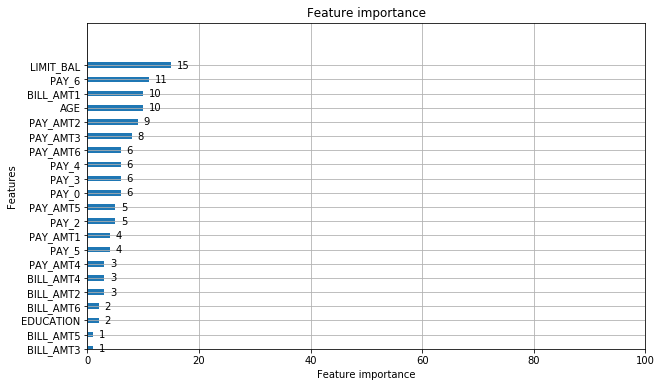

In [57]:
ax = lgb.plot_importance(gbm, height = 0.4, 
                         max_num_features = 25, 
                         xlim = (0,100), ylim = (0,23), 
                         figsize = (10,6))
plt.show()


<h2>Dimensionality reduction using feature importances</h2>

In [58]:
# For each feature of our dataset, the result of the following
# code snippet contains numbers of times a feature is used in a model.
sorted(gbm.feature_importances_,reverse=True)

[15, 11, 10, 10, 9, 8, 6, 6, 6, 6, 5, 5, 4, 4, 3, 3, 3, 2, 2, 1, 1, 0, 0]

In [64]:
# The code below aims to drop  to keep the features that are included in the most important features. 
temp = 0 
total = sum(gbm.feature_importances_)
for feature in sorted(gbm.feature_importances_, reverse=True):
    temp+=feature
    print(feature)
    if temp/total >= 0.85:
        print(feature,temp/total) # stop when we 
        break

15
11
10
10
9
8
6
6
6
6
5
5
4
4
4 0.875


In [67]:
#The above means let go of all variables after PAY_AMT_5
y_pred_prob = gbm.predict_proba(X_test)[:, 1]
auc_roc_0 = str(roc_auc_score(y_test, y_pred_prob)) # store AUC score without dimensionality reduction
print('AUC without dimensionality reduction: \n' + auc_roc_0)

AUC without dimensionality reduction: 
0.7686460477376955


In [68]:
#We can choose to drop the last 6 features from in our new model to reduce dimensionality, and thus save training time and space

X = X.drop(['PAY_5','PAY_AMT4','BILL_AMT4','BILL_AMT2','BILL_AMT6','EDUCATION','BILL_AMT5','BILL_AMT3'], axis=1)

In [69]:
# Remake our test/train set with our reduced dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=21)

reduc_estimator = lgb.LGBMClassifier(learning_rate = 0.125, metric = 'l1', 
                        n_estimators = 20, num_leaves = 38)

# Parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [x for x in range(20, 36, 2)],
    'learning_rate': [0.10, 0.125, 0.15, 0.175, 0.2]}

gridsearch = GridSearchCV(reduc_estimator, param_grid)

gridsearch.fit(X_train, y_train,
        eval_set = [(X_test, y_test)],
        eval_metric = ['auc', 'binary_logloss'],
        early_stopping_rounds = 5)
print('Best parameters found by grid search are:', gridsearch.best_params_)



/home/ajc/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


[1]	valid_0's binary_logloss: 0.649987	valid_0's auc: 0.764811
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.614878	valid_0's auc: 0.765334
[3]	valid_0's binary_logloss: 0.585872	valid_0's auc: 0.769379
[4]	valid_0's binary_logloss: 0.561615	valid_0's auc: 0.770104
[5]	valid_0's binary_logloss: 0.541663	valid_0's auc: 0.77207
[6]	valid_0's binary_logloss: 0.525011	valid_0's auc: 0.771646
[7]	valid_0's binary_logloss: 0.511302	valid_0's auc: 0.770342
[8]	valid_0's binary_logloss: 0.499137	valid_0's auc: 0.772387
[9]	valid_0's binary_logloss: 0.488921	valid_0's auc: 0.772538
[10]	valid_0's binary_logloss: 0.480526	valid_0's auc: 0.77215
[11]	valid_0's binary_logloss: 0.473288	valid_0's auc: 0.772052
[12]	valid_0's binary_logloss: 0.467178	valid_0's auc: 0.772153
[13]	valid_0's binary_logloss: 0.461907	valid_0's auc: 0.772628
[14]	valid_0's binary_logloss: 0.457719	valid_0's auc: 0.772073
[15]	valid_0's binary_logloss: 0.454001	valid_0's auc:

[5]	valid_0's binary_logloss: 0.541971	valid_0's auc: 0.768534
[6]	valid_0's binary_logloss: 0.525079	valid_0's auc: 0.769288
[7]	valid_0's binary_logloss: 0.510989	valid_0's auc: 0.770722
[8]	valid_0's binary_logloss: 0.499175	valid_0's auc: 0.770306
[9]	valid_0's binary_logloss: 0.489026	valid_0's auc: 0.770181
[10]	valid_0's binary_logloss: 0.480527	valid_0's auc: 0.770099
[11]	valid_0's binary_logloss: 0.47319	valid_0's auc: 0.770482
[12]	valid_0's binary_logloss: 0.46736	valid_0's auc: 0.770093
Early stopping, best iteration is:
[7]	valid_0's binary_logloss: 0.510989	valid_0's auc: 0.770722
[1]	valid_0's binary_logloss: 0.649736	valid_0's auc: 0.767714
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.614505	valid_0's auc: 0.770158
[3]	valid_0's binary_logloss: 0.585713	valid_0's auc: 0.770649
[4]	valid_0's binary_logloss: 0.561683	valid_0's auc: 0.772634
[5]	valid_0's binary_logloss: 0.541646	valid_0's auc: 0.775379
[6]	valid_0's binary_

[18]	valid_0's binary_logloss: 0.44543	valid_0's auc: 0.773478
[19]	valid_0's binary_logloss: 0.443565	valid_0's auc: 0.773689
[20]	valid_0's binary_logloss: 0.442102	valid_0's auc: 0.772553
[21]	valid_0's binary_logloss: 0.440773	valid_0's auc: 0.772489
[22]	valid_0's binary_logloss: 0.439848	valid_0's auc: 0.771572
[23]	valid_0's binary_logloss: 0.438724	valid_0's auc: 0.772306
[24]	valid_0's binary_logloss: 0.438093	valid_0's auc: 0.772286
Early stopping, best iteration is:
[19]	valid_0's binary_logloss: 0.443565	valid_0's auc: 0.773689
[1]	valid_0's binary_logloss: 0.650046	valid_0's auc: 0.7579
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.614805	valid_0's auc: 0.768218
[3]	valid_0's binary_logloss: 0.585989	valid_0's auc: 0.766994
[4]	valid_0's binary_logloss: 0.56196	valid_0's auc: 0.767616
[5]	valid_0's binary_logloss: 0.541971	valid_0's auc: 0.768534
[6]	valid_0's binary_logloss: 0.525079	valid_0's auc: 0.769288
[7]	valid_0's bina

[1]	valid_0's binary_logloss: 0.639997	valid_0's auc: 0.7579
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.598647	valid_0's auc: 0.768051
[3]	valid_0's binary_logloss: 0.56668	valid_0's auc: 0.769974
[4]	valid_0's binary_logloss: 0.541144	valid_0's auc: 0.770928
[5]	valid_0's binary_logloss: 0.520396	valid_0's auc: 0.771398
[6]	valid_0's binary_logloss: 0.504237	valid_0's auc: 0.771318
[7]	valid_0's binary_logloss: 0.490907	valid_0's auc: 0.770627
[8]	valid_0's binary_logloss: 0.48037	valid_0's auc: 0.769352
[9]	valid_0's binary_logloss: 0.471982	valid_0's auc: 0.768651
[10]	valid_0's binary_logloss: 0.464704	valid_0's auc: 0.769834
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.520396	valid_0's auc: 0.771398
[1]	valid_0's binary_logloss: 0.639605	valid_0's auc: 0.767714
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.598235	valid_0's auc: 0.770893
[3]	valid_0's binary_loglos

[1]	valid_0's binary_logloss: 0.639605	valid_0's auc: 0.767714
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.598235	valid_0's auc: 0.770893
[3]	valid_0's binary_logloss: 0.566282	valid_0's auc: 0.772481
[4]	valid_0's binary_logloss: 0.540521	valid_0's auc: 0.774474
[5]	valid_0's binary_logloss: 0.51982	valid_0's auc: 0.775178
[6]	valid_0's binary_logloss: 0.503527	valid_0's auc: 0.774708
[7]	valid_0's binary_logloss: 0.490433	valid_0's auc: 0.77386
[8]	valid_0's binary_logloss: 0.479204	valid_0's auc: 0.77598
[9]	valid_0's binary_logloss: 0.47085	valid_0's auc: 0.774124
[10]	valid_0's binary_logloss: 0.463677	valid_0's auc: 0.774711
[11]	valid_0's binary_logloss: 0.458534	valid_0's auc: 0.773313
[12]	valid_0's binary_logloss: 0.45358	valid_0's auc: 0.773877
[13]	valid_0's binary_logloss: 0.449739	valid_0's auc: 0.773154
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.479204	valid_0's auc: 0.77598
[1]	valid_0's binary_log

[1]	valid_0's binary_logloss: 0.639997	valid_0's auc: 0.7579
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.598647	valid_0's auc: 0.768051
[3]	valid_0's binary_logloss: 0.56668	valid_0's auc: 0.769974
[4]	valid_0's binary_logloss: 0.541144	valid_0's auc: 0.770928
[5]	valid_0's binary_logloss: 0.520396	valid_0's auc: 0.771398
[6]	valid_0's binary_logloss: 0.504237	valid_0's auc: 0.771318
[7]	valid_0's binary_logloss: 0.490907	valid_0's auc: 0.770627
[8]	valid_0's binary_logloss: 0.48037	valid_0's auc: 0.769352
[9]	valid_0's binary_logloss: 0.471982	valid_0's auc: 0.768651
[10]	valid_0's binary_logloss: 0.464704	valid_0's auc: 0.769834
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.520396	valid_0's auc: 0.771398
[1]	valid_0's binary_logloss: 0.639605	valid_0's auc: 0.767714
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.598235	valid_0's auc: 0.770893
[3]	valid_0's binary_loglos

[1]	valid_0's binary_logloss: 0.630238	valid_0's auc: 0.7579
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.583809	valid_0's auc: 0.767986
[3]	valid_0's binary_logloss: 0.549496	valid_0's auc: 0.770526
[4]	valid_0's binary_logloss: 0.523184	valid_0's auc: 0.771226
[5]	valid_0's binary_logloss: 0.50331	valid_0's auc: 0.770445
[6]	valid_0's binary_logloss: 0.487805	valid_0's auc: 0.769169
[7]	valid_0's binary_logloss: 0.476158	valid_0's auc: 0.767893
[8]	valid_0's binary_logloss: 0.466896	valid_0's auc: 0.768205
[9]	valid_0's binary_logloss: 0.459388	valid_0's auc: 0.770344
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.523184	valid_0's auc: 0.771226
[1]	valid_0's binary_logloss: 0.629761	valid_0's auc: 0.767714
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.583254	valid_0's auc: 0.770839
[3]	valid_0's binary_logloss: 0.54917	valid_0's auc: 0.772405
[4]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.630238	valid_0's auc: 0.7579
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.583809	valid_0's auc: 0.767986
[3]	valid_0's binary_logloss: 0.549496	valid_0's auc: 0.770526
[4]	valid_0's binary_logloss: 0.523184	valid_0's auc: 0.771226
[5]	valid_0's binary_logloss: 0.50331	valid_0's auc: 0.770445
[6]	valid_0's binary_logloss: 0.487805	valid_0's auc: 0.769169
[7]	valid_0's binary_logloss: 0.476158	valid_0's auc: 0.767893
[8]	valid_0's binary_logloss: 0.466896	valid_0's auc: 0.768205
[9]	valid_0's binary_logloss: 0.459388	valid_0's auc: 0.770344
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.523184	valid_0's auc: 0.771226
[1]	valid_0's binary_logloss: 0.629761	valid_0's auc: 0.767714
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.583254	valid_0's auc: 0.770839
[3]	valid_0's binary_logloss: 0.54917	valid_0's auc: 0.772405
[4]	valid_0's binary_logloss

[1]	valid_0's binary_logloss: 0.620767	valid_0's auc: 0.7579
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.570096	valid_0's auc: 0.768441
[3]	valid_0's binary_logloss: 0.533829	valid_0's auc: 0.772067
[4]	valid_0's binary_logloss: 0.507845	valid_0's auc: 0.771469
[5]	valid_0's binary_logloss: 0.48866	valid_0's auc: 0.772246
[6]	valid_0's binary_logloss: 0.474513	valid_0's auc: 0.771085
[7]	valid_0's binary_logloss: 0.463801	valid_0's auc: 0.770495
[8]	valid_0's binary_logloss: 0.45602	valid_0's auc: 0.770549
[9]	valid_0's binary_logloss: 0.450541	valid_0's auc: 0.770545
[10]	valid_0's binary_logloss: 0.446428	valid_0's auc: 0.770508
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.48866	valid_0's auc: 0.772246
[1]	valid_0's binary_logloss: 0.620202	valid_0's auc: 0.767714
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.56942	valid_0's auc: 0.770509
[3]	valid_0's binary_logloss:

[1]	valid_0's binary_logloss: 0.620663	valid_0's auc: 0.764811
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.570317	valid_0's auc: 0.767494
[3]	valid_0's binary_logloss: 0.534293	valid_0's auc: 0.769038
[4]	valid_0's binary_logloss: 0.508294	valid_0's auc: 0.771713
[5]	valid_0's binary_logloss: 0.488626	valid_0's auc: 0.774199
[6]	valid_0's binary_logloss: 0.474719	valid_0's auc: 0.772056
[7]	valid_0's binary_logloss: 0.463578	valid_0's auc: 0.773318
[8]	valid_0's binary_logloss: 0.455916	valid_0's auc: 0.773168
[9]	valid_0's binary_logloss: 0.449915	valid_0's auc: 0.773491
[10]	valid_0's binary_logloss: 0.44554	valid_0's auc: 0.773798
Early stopping, best iteration is:
[5]	valid_0's binary_logloss: 0.488626	valid_0's auc: 0.774199
[1]	valid_0's binary_logloss: 0.620767	valid_0's auc: 0.7579
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.570096	valid_0's auc: 0.768441
[3]	valid_0's binary_loglo

[1]	valid_0's binary_logloss: 0.611582	valid_0's auc: 0.7579
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.557781	valid_0's auc: 0.767552
[3]	valid_0's binary_logloss: 0.520831	valid_0's auc: 0.771232
[4]	valid_0's binary_logloss: 0.495612	valid_0's auc: 0.768695
[5]	valid_0's binary_logloss: 0.477462	valid_0's auc: 0.768047
[6]	valid_0's binary_logloss: 0.464938	valid_0's auc: 0.766633
[7]	valid_0's binary_logloss: 0.455599	valid_0's auc: 0.769597
[8]	valid_0's binary_logloss: 0.449157	valid_0's auc: 0.769673
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.520831	valid_0's auc: 0.771232
[1]	valid_0's binary_logloss: 0.610929	valid_0's auc: 0.767714
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556723	valid_0's auc: 0.77257
[3]	valid_0's binary_logloss: 0.521014	valid_0's auc: 0.773214
[4]	valid_0's binary_logloss: 0.495392	valid_0's auc: 0.773113
[5]	valid_0's binary_loglos

[1]	valid_0's binary_logloss: 0.611582	valid_0's auc: 0.7579
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.557781	valid_0's auc: 0.767552
[3]	valid_0's binary_logloss: 0.520831	valid_0's auc: 0.771232
[4]	valid_0's binary_logloss: 0.495612	valid_0's auc: 0.768695
[5]	valid_0's binary_logloss: 0.477462	valid_0's auc: 0.768047
[6]	valid_0's binary_logloss: 0.464938	valid_0's auc: 0.766633
[7]	valid_0's binary_logloss: 0.455599	valid_0's auc: 0.769597
[8]	valid_0's binary_logloss: 0.449157	valid_0's auc: 0.769673
Early stopping, best iteration is:
[3]	valid_0's binary_logloss: 0.520831	valid_0's auc: 0.771232
[1]	valid_0's binary_logloss: 0.610929	valid_0's auc: 0.767714
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.556723	valid_0's auc: 0.77257
[3]	valid_0's binary_logloss: 0.521014	valid_0's auc: 0.773214
[4]	valid_0's binary_logloss: 0.495392	valid_0's auc: 0.773113
[5]	valid_0's binary_loglos

In [70]:
gbm = lgb.LGBMClassifier(learning_rate = 0.1, metric = 'l1', 
                        n_estimators = 20)
gbm.fit(X_train, y_train,
        eval_set=[(X_test, y_test)],
        eval_metric=['auc', 'binary_logloss'],
early_stopping_rounds=5)

[1]	valid_0's binary_logloss: 0.649725	valid_0's auc: 0.772154
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's binary_logloss: 0.614375	valid_0's auc: 0.778549
[3]	valid_0's binary_logloss: 0.585455	valid_0's auc: 0.779084
[4]	valid_0's binary_logloss: 0.561272	valid_0's auc: 0.779688
[5]	valid_0's binary_logloss: 0.541092	valid_0's auc: 0.779204
[6]	valid_0's binary_logloss: 0.524521	valid_0's auc: 0.778438
[7]	valid_0's binary_logloss: 0.510473	valid_0's auc: 0.777338
[8]	valid_0's binary_logloss: 0.498487	valid_0's auc: 0.777082
[9]	valid_0's binary_logloss: 0.488587	valid_0's auc: 0.776332
Early stopping, best iteration is:
[4]	valid_0's binary_logloss: 0.561272	valid_0's auc: 0.779688


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        learning_rate=0.1, max_depth=-1, metric='l1', min_child_samples=20,
        min_child_weight=0.001, min_split_gain=0.0, n_estimators=20,
        n_jobs=-1, num_leaves=31, objective=None, random_state=None,
        reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=1)

<li>We still need to compare the <b>classification accuracy </b> versus the <b>null accuracy</b> ( the accuracy that could be achieved by always predicting the most frequent class). We must always compare the two.  </li>

In [72]:
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)
print('The accuracy of prediction is:', accuracy_score(y_test, y_pred))
print('The roc_auc_score of prediction is:', roc_auc_score(y_test, y_pred))
print('The null acccuracy is:', max(y_test.mean(), 1 - y_test.mean()))

The accuracy of prediction is: 0.8206583427922814
The roc_auc_score of prediction is: 0.6585775279927082
The null acccuracy is: 0.7790389708664396


In [73]:
y_pred_prob = gbm.predict_proba(X_test)[:, 1]

In [74]:
y_pred_prob

array([0.35298437, 0.42795826, 0.38211999, ..., 0.40550914, 0.41998315,
       0.35931644])

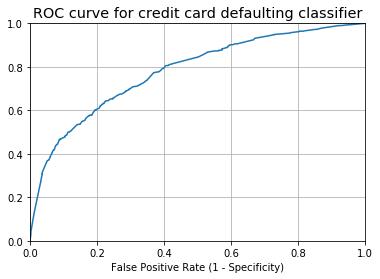

In [78]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for credit card defaulting classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.grid(True)

In [80]:
auc_roc_1 = str(roc_auc_score(y_test, y_pred_prob))
print('AUC with dimensionality reduction: \n' + auc_roc_1)
print('AUC without dimensionality reduction: \n' + auc_roc_0)

AUC with dimensionality reduction: 
0.7796879885833661
AUC without dimensionality reduction: 
0.7686460477376955


<h2>Conclusion</h2>
We were able to reduce the size of our training/test set by 26% by removing 6 features, while only giving up 0.52% in our AUC accuracy



- AUC is useful as a single number summary of classifier performance
- Higher value means that it is a better classifier
- If you randomly chose one positive and one negative observation, AUC represents the likelihood that your classifier will assign a higher predicted probability to the positive observation
- AUC is useful even when there is high class imbalance (unlike classification accuracy)



It is a good thing that the prediction accuracy is greater than the null accuracy because it shows us that the model is performing better than by just predicting the most frequent class. 

<h2>Confusion matrix </h2>

In [81]:
from sklearn import metrics
print(metrics.confusion_matrix(y_test, y_pred))

[[1954  105]
 [ 369  215]]




<b>Basic terminology</b>

- <b>True Positives (TP)</b>: we correctly predicted that they would default. 
    - 233
     
     
- <b>True Negatives (TN)</b>: we correctly predicted that they won't default.
    - 2252
     
    
- <b>False Positives (FP)</b>: we incorrectly predicted that they did default.
    - 108
    - Falsely predict positive
    - Type I error
      
       
- <b>False Negatives (FN)</b>: we incorrectly predicted that they didn't default. 
    - 407
    - Falsely predict negative
    - Type II error

